# Implementing CNNs for image recognition.

In the last lab, we implemented an MLP to recognise handwritten digits. MLPs are very useful approximators but they don't have the ability to capture spatial information, because every input is considered the same way against every other input. Convolutional Neural Network (CNN), on the other hand, capture spatial information through convolution. It makes them more suitable to handle structured inputs, such as images.

As usual, we will approach this problem in three steps : defining the dataset, defining the model, and performing the optimization.

The dataset will this time be a set of image from a very popular dataset : CFAR 10. If you cannot use this dataset then you can reuse the handwritten digits dataset from the MLP lab.

## Setup the environement

We first setup the environnement and the necessary inputs as usual.

In [ ]:
!pip install numpy matplotlib scikit-learn

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

## Dataset preparation

We will download the CFAR10 dataset. It's a collection of 50000 images for training and 10000 images for test. The images are 32x32 so it is quite a big dataset.

You can find it by following this [link](https://www.cs.toronto.edu/~kriz/cifar.html)

TODO : download the CFAR dataset by following the link above.

If you have problem with the data, or not enough space, you can solve this lab by using the MNIST dataset from the previous lab instead.

In [7]:
## TODO : download CFAR
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

file = "cifar-10-batches-py/data_batch_1"

batch_1 = unpickle(file)
b1 = batch_1[b'data']

It is common practice to have the dataset as an object we can query to get the next sample. The following code implements the CFAR dataset for the training set.

In [35]:
class CFARDataset :
    def __init__(self, root):
        self.root = root
        ## first load the data, you need a few hundred MB of RAM to load it entirely
        ## if you don't have enough RAM you can load less batches
        self.data = []
        self.target = []
        for i in range(1,6) :
            data_batch = unpickle(root + f"data_batch_{i}")
            self.data.append(data_batch[b'data'])
            self.target.append(np.array(data_batch[b'labels']))
        
        self.data = np.concatenate(self.data)
        self.target = np.concatenate(self.target)
        self.data = self.data.reshape(-1, 3,32,32)


    def __getitem__(self, index): ## used to be able to write dataset[index]
        return self.data[index], self.target[index]

In [36]:
ds = CFARDataset("cifar-10-batches-py/")

## We can see the stats on the dataset, the data is accessed the same way as in previous lab.
print(ds.data.shape)
print(ds.target.shape)

(50000, 3, 32, 32)
(50000,)


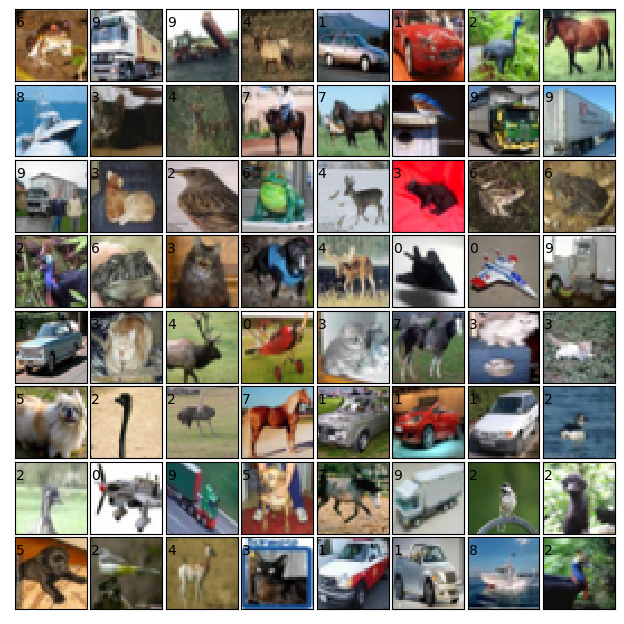

In [43]:
## Let's visualize a few images 
import matplotlib.pyplot as plt
# set up the figure
fig = plt.figure(figsize=(6, 6))  # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# plot the digits: each image is 8x8 pixels
for i in range(64):
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(ds.data[i].transpose((1,2,0)), cmap=plt.cm.binary, interpolation='nearest')
    
    # label the image with the target value
    ax.text(0, 7, str(ds.target[i]))

The CFAR dataset comes with the data already split into train and test, the following code is an implementation of the dataset that allows to load data depending on the value of is_train.

In [29]:
class CFARDataset :
    def __init__(self, root, is_train):
        self.root = root
        self.is_train = is_train
        ## first load the data, you need a few hundred MB of RAM to load it entirely
        ## if you don't have enough RAM you can load less batches
        self.train_data = []
        self.train_target = []
        for i in range(1,6) :
            data_batch = unpickle(root + f"data_batch_{i}")
            self.data.append(data_batch[b'data'])
            self.target.append(np.array(data_batch[b'labels']))
        
        self.train_data = np.concatenate(self.data)
        self.train_target = np.concatenate(self.target)
        self.train_data = self.data.reshape(-1, 32,32,3)

        test_batch = unpickle(root + f"data_batch_{i}")
        self.test_data = test_batch[b'data']
        self.test_target = np.array(test_batch[b'labels'])

    @property  ## this allows to call data like an attribute : self.data instead of self.data()
    def data(self):
        return self.train_data if self.is_train else self.test_data
    
    @property
    def target(self):
        return self.train_target if self.is_train else self.test_target
    
    
    def __getitem__(self, index): ## used to be able to write dataset[index]
        return self.data[index], self.target[index]

### Data preprocessing

As we did in the previous lab, we need to preprocess the data. The samples are already all the same size and same color pattern, what is left to do is normalization.

In [ ]:
## TODO: find the normalization parameters and normalize the images between 0 and 1 

### Validation split

The data is already split into a train and a test set. We will now introduce a new set that is also important for training : the validation set.

The validation set is an important set for training a model. It's a portion of the train set that we reserve aside to monitor the model's performance during training. It helps identify overfitting (when the model performs well on training data but poorly on new data) and provides a way to choose the best version of the model before final testing. This ensures that the model performs well on real-world data.

Typically, we reserve 20% of the train set for validation.

In [ ]:
## TODO : split the train set into train-validation.

## Implementation of the convolutional neural network.

### Forward pass

A 2D Conv Layer takes as input a 2D image and outputs a feature map by running filters on the image. More details and visualization [here](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53)

A conv layer has parameters that govern its behaviour : 
- The kernel size or size of the filter, a standard size is 3x3.
- The number of filters, this will determine the number of output feature maps.
- The stride, it controls how much pixels should the filter jump when computing the next value.

You can also add padding around the image if you want the output feature map to have the same dimension as the input.

For example suppose we have ConvLayer with 10 filters of size $5\times5$, that receives an input with 3 channels : 
- The number of parameter per filter is : $5 \times 5 \times 3$ : filter_size $\times$ input_channels.
- The number of output feature maps is $10$ : the number of filters.

Each of the 10 filters slides over the input image, computing a dot product between the filter's weights and the corresponding region of the input image.

We can write the computation of a convolution layer for an image patch $x$ as : 
$$ y = F \circledast x + b$$

Where $x$ is a patch of the same size as the filter $F$, $y$ is a pixel value and $b$ is the bias of the filter. $\circledast $ is the convolution opreration.

### Backward pass

We now need to compute the gradient of the convolution operation to update the filter weight and the bias. For this layer we need to compute three gradients :
$$ \frac{\mathcal{L}}{dx} $$
Where $y$  is the output feature map and $x$ is the input.
$$ \frac{d\mathcal{L}}{dF} $$
Where $F$ is the filter tensor (size filter_size_x $\times$ filter_size_y $\times$ input_channels)
$$ \frac{d\mathcal{L}}{db} $$
Where $b$ is the bias of the filter.



We give the expressions of the gradients here :
$$ \frac{d\mathcal{L}}{db} =  \frac{d\mathcal{L}}{dy} $$
$$ \frac{d\mathcal{L}}{dF} = x \circledast \frac{d\mathcal{L}}{dy}$$
$$ \frac{\mathcal{L}}{dx} = F^* \circledast pad(\frac{d\mathcal{L}}{dy}, x)$$

Where $F^*$ is the filter $F$ rotated by $180°$ and $pad(a,b)$ is a function that pads a to match the size of b. 

Similarly to last time, we will implement the convolutional layer. We provide a structure consistent with the previous lab's implementation, but you can come up with your own.

Convolution is more difficult to implement. You can start by implementing a convolution function that computes one pixel given a window of the same size of the filter, and then apply it to each window.
The stride and padding are optional.

You can also start with one filter, and then apply the same function to every filter to get all the feature maps.

In [46]:
## TODO : Implement the convolutional layer
class Convolution2DLayer :
    """This implements the 2D convolution layer, it takes as input a matrix and runs its filters."""
    def __init__(self, input_dim, kernel_size, num_filters, stride=None, padding=None):
        pass

    def forward(self, x):
        """This is the forward pass, to compute the output y_pred given the input"""
        return x
    
    def backward(self, gradient):
        """The backward pass allows you to compute the gradient of this layer"""
        return gradient
    
    def step(self, alpha):
        """Take a gradient descent step"""
        pass 

    def __call__(self, x) : 
        """To ensure we can call this module."""
        return self.forward(x)

#### ReLU 

We need an activation function for our convolution layer. Sigmoid is a possible choice but we will use ReLU (rectified Linear Unit). The reLU function is defined as follows : 

$$ ReLU(x) = max(0, x) $$

It's a simple non-linear function that outputs 0 if $x$ is negative, and $x$ otherwise. Its derivative with respect to x is :
$$ ReLU'(x) = \mathbf{1}(x > 0) $$

In [ ]:
## TODO : implement relu function and layer forward/backward
def relu(x):
    return 0

class ReLULayer : 
    """This implements the ReLU layer"""
    
    def __init__(self):
        pass

    def forward(self, x):
        """This is the forward pass, computes the reLU"""
        return x
    
    def backward(self, gradient):
        """Computes the gradient of relu for backpropagation.
        Hint : there is no parameter, so only the gradient w.r.t the input is necessary"""
        return gradient

    def step(self, alpha):
        pass
    
    def __call__(self):
        pass

#### Pooling

The last layer we will implement is a pooling layer. A pooling layer takes as input a feature map and returns a new, downsized feature map, where each pixel is the max (for maxpooling) or the average (for average pooling) of the corresponding window in the input.

For example, if the image is of size $10\times 10$, a pooling layer of window size $2\times2$ will produce an output feature map of size $5\times5$.

Pooling layers are useful for downsampling the feature maps and working with smaller size input, which improves the computational efficiency of the model.

In [47]:
## TODO : implement a pooling layer, you can choose between max pooling or average pooling
## Hint : the pooling window is applied to each feature map
class PoolingLayer : 
    """This implements the pooling layer"""
    
    def __init__(self, window_size):
        pass

    def forward(self, x):
        """This is the forward pass, computes the pooling"""
        return x
    
    def backward(self, gradient):
        """Computes the gradient of pooling for backpropagation.
        Hint : there is no parameter, so only the gradient w.r.t the input is necessary."""
        return gradient

    def step(self, alpha):
        pass
    
    def __call__(self):
        pass

Since we are in a classification problem, we need to be able to output a vector of probabilities for each class. This is a 1D output, while our input is 2D.
We thus need to use a linear layer (or an MLP) at the end of our model to be able to transform the 2D input from the convolution layers to the desired output.

You can reuse your previous lab's implementation here for the linear layer. Don't forget to use activation and pooling layers.

In [ ]:
## TODO : implement the full CNN
class CNN :
    """This implements the CNN, it's a combination of convolution layers and linear layers to output the prediction for each class."""
    def __init__(self):
        pass

    def forward(self, x):
        """This is the forward pass, to compute the output y_pred given the input. It should pass through the layers of the model"""
        return x
    
    def backward(self, gradient):
        """Computes the gradient of each layers"""
        return gradient

    def __call__(self):
        pass

In [44]:
## TODO : instantiate your model here and verify that it works on the dataset you have.
## It should be able to take a (3 x 32 x 32) image and output a vector of size 10.

## Training procedure.

Since we are in a classification problem, the training procedure is the same as the previous lab. We will use cross entropy as our loss function.

Implement the training loop and train your model. Your code from the previous lab should work.

There is one modification, you should implement a `validation` loop that makes use of the validation dataset.

In [1]:
## TODO : implement the softmax and cross entropy loss

In [45]:
# TODO : implement the training loop with the validation loop
def train(model, train_data, train_labels, validation_data, validation_labels, lr, num_epochs):
    best_model = None  ## should be returned at the end of the training
    best_model_validation_loss = None
    ### Loop over epochs
    for epoch in num_epochs : 
        pass
        ### TODO : training loop, similar to previous lab

        ### TODO : implement validation loop that runs every few epoch.
        ### it should allow to choose the best model as the one that minimizes validation loss
    
    return best_model

In [ ]:
# TODO : train your CNN

## Evaluation 

It's time to evaluate your model on your test data. You should compute the accuracy and recall per class. The code from the previous lab should work.
This time you need to compute and show the confusion matrix.

In [ ]:
## TODO : evaluate the model's accuracy and recall per class on the TEST set. 
## (optional) : compute and plot the confusion matrix